# Reconhecimento de Imagens e Augmentação usando Tensorflow e Keras no AWS

## Exemplo reconhecimento de espécies de flores

Um dos problemas clássicos de Aprendizado Profundo (Deep Learning) usando Redes Neurais Convolucionais (CNNs) é a identificação de flores. A partir de uma base com 4500 imagens JPEG de 5 espécies de flores com cores, tamanhos e ângulos diferentes podemos identificar a qual espécie uma foto de flor qualquer pode ser classificada.   

Este exemplo mostra uma forma usual de organização de classificação de imagens. As imagens já classificadas são colocadas em diretórios diferentes com o nome da espécie. O programa inicialmente lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação igual ao nome do diretório. Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

Aumento de dados (em inglês, augmentation) é uma técnica usada para expandir ou ampliar o conjunto de dados para treinamento do modelo usando variações dos dados existentes. Para isso, aplicamos diferentes técnicas para expandir nosso conjunto de dados de modo que ajude a treinar melhor nosso modelo com um conjunto de dados maior. O aumento de imagem (image augmentation) é uma das técnicas que podemos aplicar em um conjunto de dados de imagem para expandir nosso conjunto de dados de forma que reduza o overfitting em nosso modelo. As técnicas mais comuns são deslocar a imagem, espelhar horizontal e verticalmente, aplicar zoom e variar contraste. Essa técnica deve ser usada com cuidado, pois seu uso pode piorar a acurácia além de aumentar o tempo de processamento.

A base de dados é separada em base de treinamento e base de validação (teste). A rede é treinada com a base de treinamento e a base de validação avalia a acurácia de cada modelo utilizado e o tempo de treinamento é medido.

O primeiro modelo é o simples, com poucas camadas. O segundo é o modelo complexo com 18 camadas. Depois usaremos redes pré-treinadas. A técnica chamada aprendizagem de transferência, onde uma rede pré-treinada (treinada com cerca de um milhão de imagens genericas), é usada para extrair atributos e treinar uma nova camada no topo para classificar as imagens de flores.

No final é apresentado uma tabela comparando a acurácia e tempo de processamento do treinamento de cada modelo.

In [1]:
### Put here de env setings

In [2]:
%%bash
######################  Download dataset from S3 #######################
if [ -d "./flowers" ]
then
    echo "The dataset directory already exist!"
else
    aws s3 cp s3://lasid-flower-zip/flowers.zip ./
    unzip -uoq flowers.zip
    rm flowers.zip
fi

The dataset directory already exist!


In [3]:
# Load libs
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib
from time import perf_counter

# AWS SageMaker python SDK
import sagemaker
import boto3
#from sagemaker import get_execution_role
#import s3fs
#from fs import open_fs
#from fs_s3fs import S3FS

from sagemaker import get_execution_role
role = get_execution_role()

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

TF version: 2.3.3
GPU is available
AWS Region: us-east-1
RoleArn: arn:aws:iam::388010949471:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


## Define hyperparameters

In [4]:
# Set hyperparameters
VAL_SAMPLE = 0.2
BATCH_SIZE = 50
SHUFFLE_BUFFER = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=5

In [5]:
# Estrutura dos diretorios
#
# data_repo / train / dandelion  / image_x.jpg ... 
#                   / daisy      / image_x.jpg ...
#                   / sunflower  / image_x.jpg ...
#                   / rose       / image_x.jpg ...
#                   / tulip      / image_x.jpg ...
# data_repo / validation / ....
#
# data_repo / test / ...
#

# Set main images directory
data_repo = "/home/ec2-user/SageMaker/lasid-image-dl-aws/flowers/flower_photos"

# Set train directory
train_dir = pathlib.Path(data_repo+"/train")

# Set validation directory
val_dir =  pathlib.Path(data_repo+"/validation")

# Set test directory
test_dir =  pathlib.Path(data_repo+"/test")

## Bibliotecas úteis

In [6]:
# Print some flowers
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

## Leitura images do repositorio

In [42]:
# Count the number of flower images and set dataset size
SIZE_OF_TRAIN_DATASET = len(list(train_dir.glob('*/*.jpg')))
SIZE_OF_VAL_DATASET = len(list(val_dir.glob('*/*.jpg')))
SIZE_OF_TEST_DATASET = len(list(test_dir.glob('*/*.jpg')))

print("Number of train images: ",SIZE_OF_TRAIN_DATASET)
print("Number of validation images: ",SIZE_OF_VAL_DATASET)
print("Number of test images: ",SIZE_OF_TEST_DATASET)

Number of train images:  3540
Number of validation images:  80
Number of test images:  50


In [8]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['daisy' 'sunflowers' 'dandelion' 'tulips' 'roses']


## Image Processing and Augmentation

In [9]:
#Set start time for prepare images
start_time = perf_counter()

# Configuring Image generator to execute image augmentation in training data
train_datagen = ImageDataGenerator(
#    validation_split=VAL_SAMPLE,    # Split validation data
    rescale=1./255,                  # scale images from integers 0-255 to floats 0-1.
#    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True 
)

# Configuring Image generator to rescale image in validation and test data (they dont need augmentation)
val_datagen = ImageDataGenerator(
#    validation_split=VAL_SAMPLE,  # Split validation data
    rescale=1./255,                # scale images from integers 0-255 to floats 0-1.
)

In [10]:
# Create augmented training dataset reading images from directory
train_ds = train_datagen.flow_from_directory(
    train_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 3540 images belonging to 5 classes.


In [11]:
# Create validation dataset reading images from directory
val_ds = val_datagen.flow_from_directory(
    val_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 80 images belonging to 5 classes.


In [12]:
# Create test dataset reading images from directory
test_ds = val_datagen.flow_from_directory(
    test_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 50 images belonging to 5 classes.


In [13]:
# Calculate train and validation step
STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size

In [14]:
time_ip = perf_counter() - start_time
tf.print("Image processing time: ", time_ip, "s")

Image processing time:  0.33338503899994976 s


(50, 224, 224, 3) (50, 5)


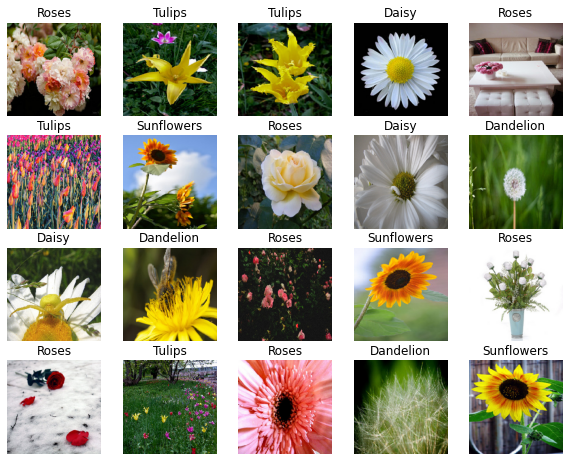

In [15]:
# Print some images with label
images, labels = next(val_ds)
print(images.shape, labels.shape)
show_batch(images, labels)

# Create Convolutional Neural Network (CNN) Model

## Simple Model

In [16]:
start_time = perf_counter()

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
], name = 'Simple_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)            

In [17]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
70/70 [==============================] - 37s 536ms/step - loss: 1.6005 - accuracy: 0.2095 - val_loss: 1.6037 - val_accuracy: 0.1000
Epoch 2/5
70/70 [==============================] - 35s 503ms/step - loss: 1.6009 - accuracy: 0.2458 - val_loss: 1.6128 - val_accuracy: 0.1800
Epoch 3/5
70/70 [==============================] - 35s 497ms/step - loss: 1.6033 - accuracy: 0.2436 - val_loss: 1.6182 - val_accuracy: 0.1400
Epoch 4/5
70/70 [==============================] - 35s 496ms/step - loss: 1.6010 - accuracy: 0.2542 - val_loss: 1.5967 - val_accuracy: 0.2800
Epoch 5/5
70/70 [==============================] - 35s 498ms/step - loss: 1.5650 - accuracy: 0.2885 - val_loss: 1.5981 - val_accuracy: 0.2400


### Evaluating the Simple CNN Model Performance

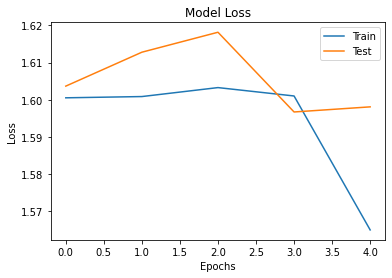

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

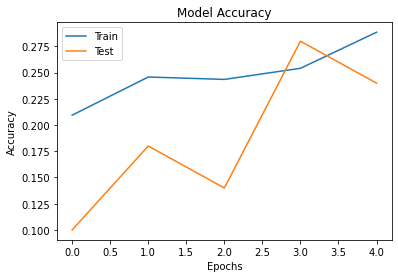

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
train_loss_sm, train_acc_sm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_sm, test_acc_sm = model.evaluate(test_ds, batch_size=BATCH_SIZE)
time_sm = perf_counter() - start_time
print(time_sm)

1/1 [==============================] - 0s 1ms/step - loss: 1.5964 - accuracy: 0.2000
257.979377044


## Complex Model 

In [21]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
], name = 'Complex_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Complex_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)      

In [22]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
70/70 [==============================] - 36s 516ms/step - loss: 1.5628 - accuracy: 0.3057 - val_loss: 1.6006 - val_accuracy: 0.2800
Epoch 2/5
70/70 [==============================] - 36s 509ms/step - loss: 1.5230 - accuracy: 0.3817 - val_loss: 1.5248 - val_accuracy: 0.3800
Epoch 3/5
70/70 [==============================] - 35s 507ms/step - loss: 1.5032 - accuracy: 0.4011 - val_loss: 1.5487 - val_accuracy: 0.3600
Epoch 4/5
70/70 [==============================] - 35s 506ms/step - loss: 1.4988 - accuracy: 0.4057 - val_loss: 1.5423 - val_accuracy: 0.3600
Epoch 5/5
70/70 [==============================] - 36s 510ms/step - loss: 1.5005 - accuracy: 0.4034 - val_loss: 1.5035 - val_accuracy: 0.4000


### Evaluating the Complex CNN Model Performance

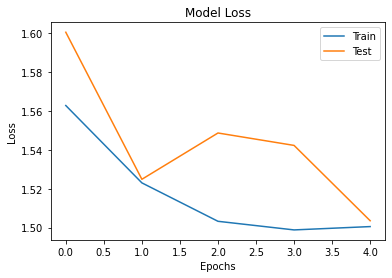

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

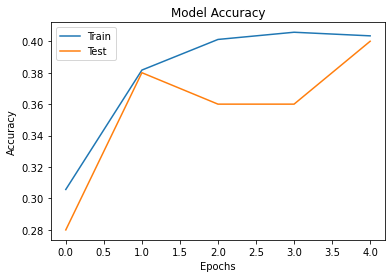

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [25]:
train_loss_cm, train_acc_cm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_cm, test_acc_cm = model.evaluate(test_ds, batch_size=BATCH_SIZE)
time_cm = perf_counter() - start_time
print(time_cm)

1/1 [==============================] - 0s 1ms/step - loss: 1.5747 - accuracy: 0.3200
221.16110549000007


## Transfer Learning: VGG19 Pre-trained Model

In [26]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
], name = 'VGG19_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "VGG19_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [27]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
70/70 [==============================] - 36s 521ms/step - loss: 1.5041 - accuracy: 0.4000 - val_loss: 1.5845 - val_accuracy: 0.3200
Epoch 2/5
70/70 [==============================] - 35s 506ms/step - loss: 1.5059 - accuracy: 0.3977 - val_loss: 1.4823 - val_accuracy: 0.4200
Epoch 3/5
70/70 [==============================] - 35s 503ms/step - loss: 1.5217 - accuracy: 0.3831 - val_loss: 1.5048 - val_accuracy: 0.4000
Epoch 4/5
70/70 [==============================] - 35s 506ms/step - loss: 1.5475 - accuracy: 0.3570 - val_loss: 1.6448 - val_accuracy: 0.2600
Epoch 5/5
70/70 [==============================] - 36s 508ms/step - loss: 1.4999 - accuracy: 0.4049 - val_loss: 1.5648 - val_accuracy: 0.3400


### Evaluating the VGG19 CNN Model Performance

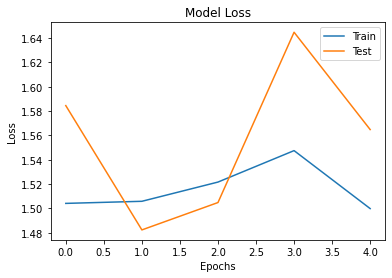

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

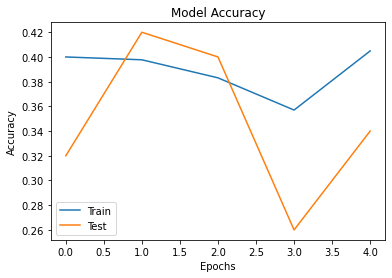

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [30]:
train_loss_vg, train_acc_vg = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_vg, test_acc_vg = model.evaluate(test_ds, batch_size=BATCH_SIZE)
time_vg = perf_counter() - start_time
print(time_vg)

1/1 [==============================] - 0s 1ms/step - loss: 1.5438 - accuracy: 0.3600
223.14673517699998


## Transfer Learning: ResNet50 Pre-trained Model

In [31]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'ResNet50_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 25,691,013
Trainable params: 2,103,301
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
70/70 [==============================] - 36s 510ms/step - loss: 1.5818 - accuracy: 0.3003 - val_loss: 1.6184 - val_accuracy: 0.2800
Epoch 2/5
70/70 [==============================] - 35s 503ms/step - loss: 1.5608 - accuracy: 0.3272 - val_loss: 1.5119 - val_accuracy: 0.4000
Epoch 3/5
70/70 [==============================] - 35s 504ms/step - loss: 1.5606 - accuracy: 0.3350 - val_loss: 1.5745 - val_accuracy: 0.3200
Epoch 4/5
70/70 [==============================] - 35s 505ms/step - loss: 1.5564 - accuracy: 0.3355 - val_loss: 1.5181 - val_accuracy: 0.3800
Epoch 5/5
70/70 [==============================] - 35s 502ms/step - loss: 1.5615 - accuracy: 0.3335 - val_loss: 1.5301 - val_accuracy: 0.3800


### Evaluating the Resnet CNN Model Performance

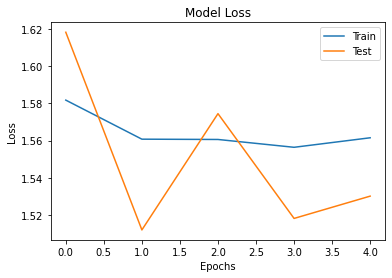

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

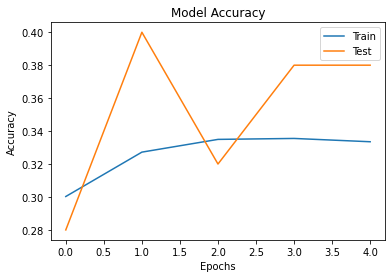

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [35]:
train_loss_rn, train_acc_rn = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_rn, test_acc_rn = model.evaluate(test_ds, batch_size=BATCH_SIZE)
time_rn = perf_counter() - start_time
print(time_rn)

1/1 [==============================] - 0s 1ms/step - loss: 1.6174 - accuracy: 0.2600
223.62527317600006


## Transfer Learning: InceptionV3 Pre-trained Model 

In [36]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'InceptionV3_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "InceptionV3_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 21,821,221
Trainable params: 14,341
Non-trainable params: 21,806,880
_________________________________________________________________


In [37]:
history = model.fit(train_ds, validation_data=val_ds, validation_steps=STEP_SIZE_VALID,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN)

Epoch 1/5
70/70 [==============================] - 36s 510ms/step - loss: 1.1850 - accuracy: 0.7246 - val_loss: 1.0876 - val_accuracy: 0.8400
Epoch 2/5
70/70 [==============================] - 35s 496ms/step - loss: 1.0760 - accuracy: 0.8358 - val_loss: 1.1096 - val_accuracy: 0.8400
Epoch 3/5
70/70 [==============================] - 35s 495ms/step - loss: 1.0515 - accuracy: 0.8636 - val_loss: 1.0513 - val_accuracy: 0.8800
Epoch 4/5
70/70 [==============================] - 35s 499ms/step - loss: 1.0382 - accuracy: 0.8748 - val_loss: 1.0765 - val_accuracy: 0.8200
Epoch 5/5
70/70 [==============================] - 35s 498ms/step - loss: 1.0282 - accuracy: 0.8831 - val_loss: 1.0387 - val_accuracy: 0.8600


### Evaluating the InceptionV3 CNN Model Performance

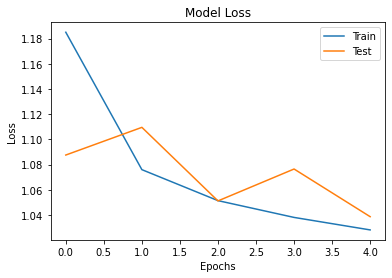

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

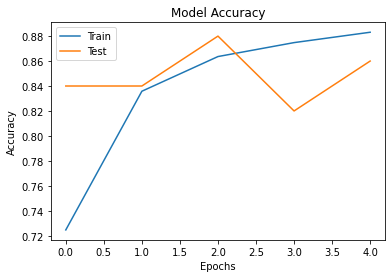

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [40]:
#train_loss_iv, train_acc_iv 
train_loss_iv, train_acc_iv = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_iv, test_acc_iv = model.evaluate(test_ds, batch_size=BATCH_SIZE)
time_iv = perf_counter() - start_time
print(time_iv)

1/1 [==============================] - 0s 1ms/step - loss: 1.1231 - accuracy: 0.7800
224.0762216180001


## Sumary  

In [41]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",(1-VAL_SAMPLE)*100,"%  Test sample = ",VAL_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  3540    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 50         Epochs = 5        

Processing images:                                          time = 0.3 s
Simple Model:         train_acc = 0.25    test_acc = 0.20   time = 258.0 s
Complex Model:        train_acc = 0.41    test_acc = 0.32   time = 221.2 s
VGG19:                train_acc = 0.41    test_acc = 0.36   time = 223.1 s
ResNet50:             train_acc = 0.35    test_acc = 0.26   time = 223.6 s
InceptionV3:          train_acc = 0.90    test_acc = 0.78   time = 224.1 s
